# AI Text Summarizer

### Import Requirements

In [1]:
# python3 -m venv venv
# source venv/bin/activate

In [1]:
%pip install rouge_score
%pip install evaluate
%pip install --upgrade -q wandb
%pip install --upgrade datasets
%pip install python-dotenv
# %pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cpu
%pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu121
%pip install --upgrade transformers
%pip install --upgrade transformers[torch]
%pip install seaborn
%pip install torch-directml
%pip install pymupdf


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Users/bshowell/Desktop/school/winter 24-25/480/.venv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Users/bshowell/Desktop/school/winter 24-25/480/.venv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Users/bshowell/Desktop/school/winter 24-25/480/.venv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Attempting uninstall: datasets
    Found existing installation: datasets 3.2.0
    Uninstalling datasets-3.2.0:
      Successfully uninstalled datasets-3.2.0

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Users/bshow

In [35]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline, set_seed
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import AutoTokenizer

import datasets
from datasets import Dataset
from datasets import DatasetDict

from evaluate import load

from tqdm import tqdm

import wandb
import huggingface_hub

import nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt_tab")

import warnings
warnings.filterwarnings('ignore')

import evaluate



[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/bshowell/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [36]:
# verifying CUDA is available
print("Torch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available()) # should be true if your graphics card is captable with NVIDIA CUDA
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

Torch Version: 2.6.0
CUDA Available: False
CUDA Version: None
Number of GPUs: 0
GPU Name: No GPU detected


In [37]:
# Load environment variables from .env file
load_dotenv()

# Retrieve tokens from environment variables
huggingface_token = os.getenv("HUGGINGFACE_TOKEN")
wandb_token = os.getenv("WANDB_API_KEY")

In [38]:
# log in to wandb
wandb.login(key=wandb_token)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [39]:
# initializing/creating wandb project
#os.environ["WANDB_MODE"] = "offline" # TODO: trouble connecting to wandb due to restricting network, so keeping it offline for now
wandb.init(project="ai-text_summmarizer")

In [40]:
# log in to Hugging Face Hub
huggingface_hub.login(token=huggingface_token)

In [41]:
# Check if CUDA or MPS is available and set the device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)

# Model checkpoint
model_ckpt = "facebook/bart-base"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Device: mps


In [42]:
# Data Analysis
dataset_paths = 'bbc-news-dataset'
articles_path = 'news-articles'
bullets_path = 'bullets'

articles = []
bullets = []
file_arr = []



folders = os.listdir(dataset_paths + '/' + articles_path)

for folder in folders:
    files = os.listdir(dataset_paths + '/' + articles_path + '/' + folder)
    for file in files:
        article_file_path = os.path.join(dataset_paths, articles_path, folder, file)
        bullets_file_path = os.path.join(dataset_paths, bullets_path, folder, file)

        try:
            with open (article_file_path,'r') as f:
                articles.append('.'.join([line.rstrip() for line in f.readlines()]))
            with open (bullets_file_path,'r') as f:
                bullets.append('.'.join([line.rstrip() for line in f.readlines()]))
            file_arr.append(folder + '/' + file)
        except Exception as e:
            print(f"Error reading file {folder}/{file} with error `{e}`")

In [43]:
df = pd.DataFrame({'path':file_arr,'article':articles,'bullets':bullets})
df.head()

,path,article,bullets
0,entertainment/289.txt,Musicians to tackle US red tape..Musicians' gr...,- British musicians are reportedly disadvantag...
1,entertainment/262.txt,"U2's desire to be number one..U2, who have won...",- U2 wants to be the biggest band ever..- U2 h...
2,entertainment/276.txt,Rocker Doherty in on-stage fight..Rock singer ...,- Pete Doherty has been involved in a fight wi...
3,entertainment/060.txt,Snicket tops US box office chart..The film ada...,"- A Series of Unfortunate Events, starring Jim..."
4,entertainment/074.txt,Ocean's Twelve raids box office..Ocean's Twelv...,- Ocean's Twelve has gone straight to number o...


In [44]:
# removing nans if any

print("Before:\n", df.isnull().sum(), "\n", sep="")
df.dropna(inplace=True)
print("After:\n", df.isnull().sum(), sep="")

Before:
path       0
article    0
bullets    0
dtype: int64

After:
path       0
article    0
bullets    0
dtype: int64


In [45]:
# crating function to count the words in each sample

def word_count(sentence):
    sentences = sentence.split()
    return len(sentences)

In [46]:
# creating new columns of word numbers

df['num_words_article'] = df['article'].apply(word_count)
df['num_words_bullets'] = df['bullets'].apply(word_count)
df.head()

,path,article,bullets,num_words_article,num_words_bullets
0,entertainment/289.txt,Musicians to tackle US red tape..Musicians' gr...,- British musicians are reportedly disadvantag...,372,55
1,entertainment/262.txt,"U2's desire to be number one..U2, who have won...",- U2 wants to be the biggest band ever..- U2 h...,829,215
2,entertainment/276.txt,Rocker Doherty in on-stage fight..Rock singer ...,- Pete Doherty has been involved in a fight wi...,354,102
3,entertainment/060.txt,Snicket tops US box office chart..The film ada...,"- A Series of Unfortunate Events, starring Jim...",174,46
4,entertainment/074.txt,Ocean's Twelve raids box office..Ocean's Twelv...,- Ocean's Twelve has gone straight to number o...,248,75


In [47]:
# getting statistical info about the word lenghths

df.describe()

,num_words_article,num_words_bullets
count,2225.000000,2225.000000
mean,379.314607,77.142472
std,235.032779,36.709791
min,87.000000,6.000000
25%,242.000000,53.000000
50%,327.000000,70.000000
75%,465.000000,92.000000
max,4377.000000,481.000000


Upper whisker: 799.0
Q3: 465.0
Q2: 327.0
Q1: 242.0
Lower whisker: 87.0


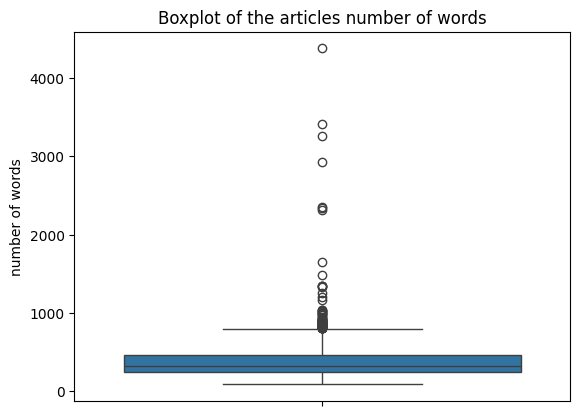

In [48]:
sns.boxplot(df["num_words_article"])
plt.ylabel("number of words")
plt.title("Boxplot of the articles number of words")

lines = plt.gca().lines[:6]
all_lines = [lines[i].get_ydata()[0] for i in range(5)]

Q1,Q3,article_lower_whisker,article_upper_whisker, Q2 = all_lines

print("Upper whisker:", article_upper_whisker)
print("Q3:", Q3)
print("Q2:", Q2)
print("Q1:", Q1)
print("Lower whisker:", article_lower_whisker)

Upper whisker: 150.0
Q3: 92.0
Q2: 70.0
Q1: 53.0
Lower whisker: 6.0


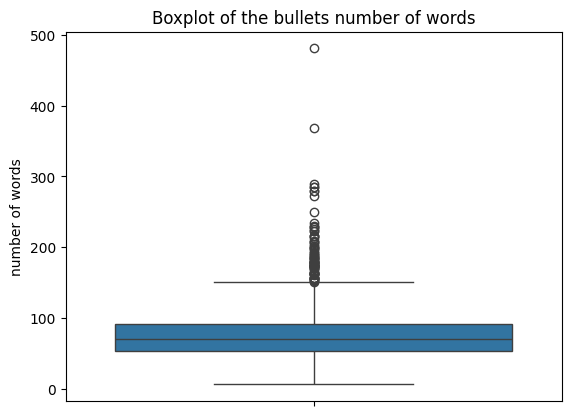

In [49]:
sns.boxplot(df["num_words_bullets"])
plt.ylabel("number of words")
plt.title("Boxplot of the bullets number of words")

lines = plt.gca().lines[:6]
all_lines = [lines[i].get_ydata()[0] for i in range(5)]

Q1,Q3,bullets_lower_whisker,bullets_upper_whisker, Q2 = all_lines

print("Upper whisker:", bullets_upper_whisker)
print("Q3:", Q3)
print("Q2:", Q2)
print("Q1:", Q1)
print("Lower whisker:", bullets_lower_whisker)

In [50]:
# removing the samples of very long sequences

new_df = df[(df['num_words_bullets'] <= bullets_upper_whisker) & (df['num_words_article'] <= article_upper_whisker)]
new_df

,path,article,bullets,num_words_article,num_words_bullets
0,entertainment/289.txt,Musicians to tackle US red tape..Musicians' gr...,- British musicians are reportedly disadvantag...,372,55
2,entertainment/276.txt,Rocker Doherty in on-stage fight..Rock singer ...,- Pete Doherty has been involved in a fight wi...,354,102
3,entertainment/060.txt,Snicket tops US box office chart..The film ada...,"- A Series of Unfortunate Events, starring Jim...",174,46
4,entertainment/074.txt,Ocean's Twelve raids box office..Ocean's Twelv...,- Ocean's Twelve has gone straight to number o...,248,75
5,entertainment/048.txt,'Landmark movies' of 2004 hailed..US film prof...,- The American Film Institute (AFI) hailed Mel...,328,86
...,...,...,...,...,...
2220,tech/086.txt,Warning over Windows Word files..Writing a Mic...,- Writing a Microsoft Word document can be a d...,456,86
2221,tech/253.txt,Fast lifts rise into record books..Two high-sp...,- Lifts in Taipei 101 Tower are the world's fa...,379,89
2222,tech/247.txt,Nintendo adds media playing to DS..Nintendo is...,- Nintendo releasing adapter for DS to play mu...,289,44
2223,tech/290.txt,Fast moving phone viruses appear..Security fir...,- New strains of the Cabir mobile phone virus ...,327,101


In [51]:
# preparing the data by training 0.03% of the dataset

# deleting some columns and shuffling the rows

# TODO - not sure if this is working with the drop as expected

new_df.drop(columns=["num_words_article","num_words_bullets","path"])
new_df = new_df.sample(frac = 0.03)
new_df.reset_index(drop=True, inplace=False)

,path,article,bullets,num_words_article,num_words_bullets
0,tech/197.txt,Smartphones suffer Skulls attack..Owners of so...,- The Skulls program is masquerading as softwa...,356,82
1,entertainment/315.txt,Hoffman hits out over modern film..Hollywood l...,- Dustin Hoffman has hit out at the quality of...,292,87
2,entertainment/140.txt,Rock band U2 break ticket record..U2 have smas...,- U2 have smashed Irish box office records wit...,226,51
3,sport/098.txt,Ronaldo considering new contract..Manchester U...,- Ronaldo refused to commit his long-term futu...,138,32
4,business/370.txt,US manufacturing expands..US industrial produc...,- ISM manufacturing index's employment index e...,208,81
...,...,...,...,...,...
58,entertainment/009.txt,Da Vinci Code is 'lousy history'..The plot of ...,- The Bishop said there was a lack of evidence...,331,90
59,business/175.txt,French consumer spending rising..French consum...,- The National Statistic Institute (INSEE) add...,205,59
60,politics/291.txt,'Super union' merger plan touted..Two of Brita...,- Amicus and the Transport and General Workers...,178,58
61,sport/246.txt,Chelsea hold Arsenal..A gripping game between ...,- Arsenal and Chelsea played to a 2-2 draw..- ...,536,38


In [52]:
# splitting the data into train and test

ratio = 0.8
split = int(len(new_df)*ratio)

train_df = new_df.iloc[:split]
test_df = new_df.iloc[split:]

In [53]:
# convert the DataFrame into DatasetDict

train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)
dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'article', 'bullets', 'num_words_article', 'num_words_bullets'],
        num_rows: 50
    })
    test: Dataset({
        features: ['path', 'article', 'bullets', 'num_words_article', 'num_words_bullets'],
        num_rows: 13
    })
})

In [54]:
max_input_length = int(article_upper_whisker)
max_target_length = int(bullets_upper_whisker)

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["bullets"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [55]:
# initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# define max input lengths
max_input_length = int(article_upper_whisker)
max_target_length = int(bullets_upper_whisker)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 13/13 [00:00<00:00, 1620.34 examples/s]


In [56]:
# ROUGE metric for automatic summarization and machine translation software in Natural Language Processing

rouge_score = evaluate.load("rouge")

In [57]:
# example on using rouge

generated_bullets = "I absolutely loved reading the Hunger Games"
reference_bullets = "I loved reading the Hunger Games"
scores = rouge_score.compute(predictions=[generated_bullets], references=[reference_bullets])
scores

{'rouge1': np.float64(0.923076923076923),
 'rouge2': np.float64(0.7272727272727272),
 'rougeL': np.float64(0.923076923076923),
 'rougeLsum': np.float64(0.923076923076923)}

In [58]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Decode generated bullets into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode reference bullets into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]

    # Compute ROUGE scores
    result = rouge_score.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    return {k: round(v, 4) for k, v in result.items()}

In [59]:
# generate summaries
summarizer = pipeline("summarization", model=model_ckpt)

def print_bullets(idx):
    article = dataset["test"][idx]["article"]
    bullets = dataset["test"][idx]["bullets"]
    g_bullets = summarizer(dataset["test"][idx]["article"])[0]["summary_text"]
    score = rouge_score.compute(predictions=[g_bullets], references=[bullets])
    scores = {k: round(v, 4) for k, v in score.items()}
    print(f"'>>> Article: {article}'")
    print(f"\n'>>> Bullets: {bullets}'")
    print(f"\n'>>> Generated Bullets: {g_bullets}'")
    print(f"\n'>>> ROUGE Score: {scores}'")


print_bullets(5)

Device set to use mps:0


'>>> Article: Indonesia 'declines debt freeze'..Indonesia no longer needs the debt freeze offered by the Paris Club group of creditors, Economics Minister Aburizal Bakrie has reportedly said...Indonesia, which originally accepted the debt moratorium offer, owes the Paris Club about $48bn (£25.5bn). Mr Bakrie told the Bisnis Indonesia newspaper that a $1.7bn donors' aid package meant that the debt moratorium was unnecessary. This aid comes on top of a previously-pledged $3.4bn package. Most of this 'normal aid' would be used to finance the country's budget deficit. The Indonesian Economics Minister explained that the money - $1.2bn in grants and $500m in soft loans - was for the rebuilding of Aceh province, which was badly hit by the tsunami of 26 December. Nevertheless, one of Mr Bakrie's deputies, Mahendra Siregar, told AFP news agency that Indonesia was still considering the offer by the Paris Club of rich creditor nations to temporarily suspend its debt payments. "What is true is th

In [60]:
# fine tuning BART model

# creating data_collator
# A data_collator is a function that takes a batch of data and collates it into a format suitable for model training

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [61]:
# removing the columns with strings because the collator won’t know how to pad these elements

tokenized_datasets = tokenized_datasets.remove_columns(dataset["train"].column_names)

In [62]:
batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_ckpt


args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-BBC",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
    run_name="text_summmarizer_bullets",
    report_to="wandb", # ensures WandB logging is enabled
    hub_token=huggingface_token,
    )

In [63]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,)

In [64]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.801700,1.348102,0.256000,0.177500,0.236800,0.237700
2,1.014400,1.114130,0.238100,0.153100,0.217400,0.218100
3,0.995100,1.213141,0.241000,0.158500,0.221300,0.217900
4,0.647300,1.168163,0.252000,0.163500,0.229200,0.227200
5,0.696000,1.150813,0.253100,0.166800,0.231200,0.231500
6,0.534800,1.212857,0.248800,0.166300,0.228100,0.227800
7,0.502500,1.195501,0.248800,0.165600,0.226600,0.225900
8,0.442700,1.202924,0.255900,0.171000,0.233500,0.233700


TrainOutput(global_step=56, training_loss=0.8073787476335254, metrics={'train_runtime': 136.8576, 'train_samples_per_second': 2.923, 'train_steps_per_second': 0.409, 'total_flos': 155809101127680.0, 'train_loss': 0.8073787476335254, 'epoch': 8.0})

In [67]:
input_text = """
The Amazon rainforest is often referred to as the "lungs of the Earth" because of its critical role in producing oxygen and absorbing carbon dioxide. It spans across several countries in South America, including Brazil, Peru, and Colombia, and is home to an incredibly diverse array of wildlife, plants, and indigenous cultures. Unfortunately, the Amazon is facing significant threats due to deforestation, illegal logging, mining, and agricultural expansion. These activities are rapidly destroying large portions of the rainforest, which not only contributes to the loss of biodiversity but also accelerates climate change by releasing stored carbon into the atmosphere.

In recent years, global efforts to protect the Amazon have intensified, with governments, NGOs, and international organizations working together to implement conservation strategies and policies. One such initiative is the creation of protected areas and indigenous territories that restrict harmful activities. However, enforcement of these measures remains a challenge, particularly in remote regions where illegal activities are rampant.

Another important issue is the role of indigenous peoples in protecting the forest. Many indigenous communities have lived in the Amazon for centuries and possess a deep understanding of the ecosystem. These communities are often the first line of defense against environmental destruction and have been leading efforts to preserve their land and culture. Yet, they face increasing threats from outside forces seeking to exploit the land for economic gain.

Climate change is exacerbating the situation, with rising temperatures and altered rainfall patterns putting additional pressure on the Amazon. Scientists have warned that if current trends continue, the rainforest could reach a tipping point where it can no longer function as a carbon sink, further accelerating global warming. Given its global significance, the fate of the Amazon is a pressing issue that requires urgent and coordinated action on a global scale.
"""

# Tokenize input text
inputs = tokenizer(input_text, return_tensors="pt", max_length=2048, truncation=True).to(device)

# Generate summary
summary_ids = model.generate(
    inputs['input_ids'],
    num_beams=8,
    max_length=200,
    min_length=100,
    early_stopping=True,
    temperature=0.8
)

# Decode the summary
bullets = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Post-process to format the summary in bullet points
# Split the summary into sentences by splitting on '.'
sentences = bullets.split("-")

# Remove any extra spaces, empty sentences, or non-english characters
sentences = ["\n - " + sentence.strip() for sentence in sentences if sentence.encode('ascii', errors='ignore').decode().strip()]

# Join sentences with bullet points
# formatted_summary = "".join(sentences)
formatted_summary = ""
for sen in sentences:
    formatted_summary = formatted_summary + sen

# Print the formatted summary
print("Summary in Bullet Points:", formatted_summary)

Summary in Bullet Points: 
 - The Amazon rainforest is often referred to as the "lungs of the Earth" because of its critical role in producing oxygen and absorbing carbon dioxide. It spans across several countries in South America, including Brazil, Peru, and Colombia, and is home to an incredibly diverse array of wildlife, plants, and indigenous cultures.
 - Many indigenous communities have lived in the Amazon for centuries and possess a deep understanding of the ecosystem.
 - The fate of the Amazon is a pressing issue that requires urgent and coordinated action on a global scale.


In [ ]:
import fitz

def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = "\n".join(page.get_text() for page in doc)
    return text